In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy.units as u # I use astropy units in everything, very helpful for bookkeeping/debugging

from lim import lim # The base intensity mapping object

matplotlib.rcParams.update({'font.size': 18,'figure.figsize':[8,7]}) # Make figures better
#matplotlib.rcParams,update({}'figure.figsize'] = [8,7]
from scipy.ndimage import gaussian_filter
plt.rcParams["mathtext.fontset"] = "dejavuserif"

In [2]:
# Initialize LineModel with default model
m = lim()
m_cii = lim('Lichen_v4', doSim = True)
m_cii_v1 = lim('Lichen', doSim = True)

Input cosmological model does not match simulations
Setting analytic cosmology to match simulation
Input cosmological model does not match simulations
Setting analytic cosmology to match simulation


In [37]:
m_cii.update(model_par = {'zdex': 0.4,
 'M0': 1900000000.0,
 'Mmin': 20000000000,
 'alpha_MH1': 0.74,
 'alpha_LCII': 0.024,
 'alpha0': -1.412,
 'gamma0': 0.31,
 'BehrooziFile': 'sfr_reinterp.dat'},
            nuObs = 226*u.GHz,
            Delta_nu = 28*u.GHz,
             dnu = 2.8*u.GHz,
            Omega_field = 4*u.deg**2,
            catalogue_file  = '/home/dongwooc/scratchspace/pprun_hiz_npz/COMAP_z5.8-7.9_960Mpc_seed_13819.npz')

In [13]:
m_cii_v1.update(nuObs = 270*u.GHz,
            Delta_nu = 40*u.GHz,
               dnu = 2.8*u.GHz)

In [14]:
a = lambda z:1/(1.+z)
# Behroozi et al 2013a parameters
nu = lambda z:np.exp(-4*a(z)**2)
log10_eps = lambda z:-1.777-0.006*(a(z)-1)*nu(z)-0.119*(a(z)-1)
log10_M1 = lambda z:11.514+(-1.793*(a(z)-1)-0.251*z)*nu(z)
alpha = lambda z:-1.412+0.731*(a(z)-1)*nu(z)
delta = lambda z:3.508+(2.608*(a(z)-1)-0.043*z)*nu(z)
gamma_f = lambda z:0.316+(1.319*(a(z)-1)+0.279*z)*nu(z)
f = lambda x, z:-np.log10(10**(alpha(z)*x)+1)+delta(z)*(np.log10(1+np.exp(x)))**gamma_f(z)/(1+np.exp(10**(-x)))
xi = lambda z:0.218-0.023*(a(z)-1)

def stellar_m(halo_m,z,scatter=False):
    sm = 10**(log10_eps(z)+log10_M1(z)+f(np.log10(halo_m/(10**log10_M1(z))),z)-f
(0,z))
    if scatter:
        rand = np.random.lognormal(-0.5*(xi(z)*np.log(10))**2,xi(z)*np.log(10))
        return sm*rand
    else:
        return sm

    
from limlam_mocker import limlam_mocker as llm
from limlam_mocker.limlam_mocker import add_log_normal_scatter
import scipy as sp
import scipy.interpolate
sigma_sfr = 0.3

tablepath = '/mnt/scratch-lustre/horlaville/clara_limlam/limCode2020-master_clara_2/sfr_reinterp.dat'

dat_zp1, dat_logm, dat_logsfr, _ = np.loadtxt(tablepath, unpack=True)
dat_logzp1 = np.log10(dat_zp1)
dat_sfr    = 10.**dat_logsfr
dat_logzp1  = np.unique(dat_logzp1)    # log(z), 1D 
dat_logm    = np.unique(dat_logm)      # log(Mhalo), 1D        
dat_sfr     = np.reshape(dat_sfr, (dat_logm.size, dat_logzp1.size))
sfr_interp_tab = sp.interpolate.RectBivariateSpline(dat_logm, dat_logzp1, dat_sfr, kx=1, ky=1)

gamma = 0.31
beta = 2.1
m_0 = 10.11
m_1 = 0.56
Z_0 = 8.779

def M_0(sfr):
    return (10**(m_0))*(sfr**(m_1))

def metal(stellar_m, M_0):
    return Z_0 - (gamma/beta)*np.log10(1 + (stellar_m/M_0)**(-beta))

In [15]:
halo_ms = m_cii_v1.halos.M
halo_zs = m_cii_v1.halos.redshift

map_zs = (m_cii_v1.mapinst.nu_rest/m_cii_v1.mapinst.nu_bincents) - 1
med_z = np.median(map_zs)

halo_sm = stellar_m(halo_ms, med_z)

halo_sfr = sfr_interp_tab.ev(np.log10(halo_ms), np.log10(halo_zs + 1))
halo_IR = halo_sfr*(1.36*(10**10))
halo_IR = add_log_normal_scatter(halo_IR, 0.3, seed = 23)


halo_M0 = M_0(halo_sfr)

halo_z = metal(halo_sm, halo_M0)

halos_cii_v1 = m_cii_v1.L_halos.value

Loading .npz catalogues...


In [ ]:
halos_cii_v2 = m_cii.L_halos.value

In [6]:
fire_galaxies_z6 = '/mnt/scratch-lustre/horlaville/clara_limlam/limCode2020-master_clara_2/fire_galaxies/fire_galaxies_z6.dat'
massive_z6, log_cii_z6, log_ir_z6 = np.loadtxt(fire_galaxies_z6, unpack=True)

mass_fire_z6 = massive_z6 < 0
fire_box_z6 = massive_z6 >= 0
fire_zs_z6 = [6 for i in range(len(massive_z6))]

fire_cii_z6 = 10**(log_cii_z6)
fire_ir_z6 = 10**(log_ir_z6)


fire_galaxies_z8 = '/mnt/scratch-lustre/horlaville/clara_limlam/limCode2020-master_clara_2/fire_galaxies/fire_galaxies_z8.dat'
massive_z8, log_cii_z8, log_ir_z8 = np.loadtxt(fire_galaxies_z8, unpack=True)

mass_fire_z8 = massive_z8 < 0
fire_box_z8 = massive_z8 >= 0
fire_zs_z8 = [8 for i in range(len(massive_z8))]

fire_cii_z8 = 10**(log_cii_z8)
fire_ir_z8 = 10**(log_ir_z8)

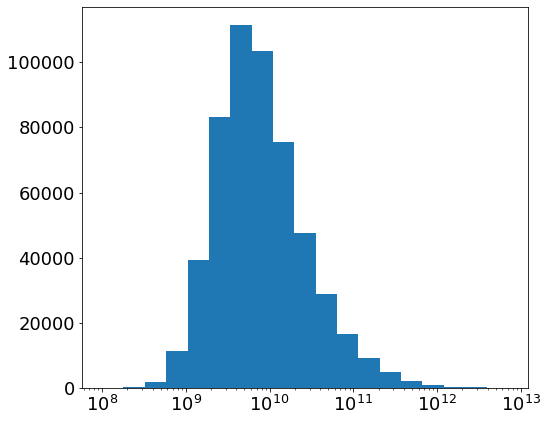

In [7]:
_, ir_bins, _ = plt.hist(halo_IR, bins = np.logspace(np.log10(10**8), np.log10(7*(10**12)), 20))
plt.xscale('log')

In [8]:
ir_center = (ir_bins[:-1] + ir_bins[1:]) / 2

In [9]:
def reg_ir(ir_bin, vnzn, halos_cii):

    ind = [0 for i in range(len(ir_bin) - 1)]
    med = [0 for i in range(len(ir_bin) - 1)]
    mean = [0 for i in range(len(ir_bin) - 1)]

    perc68_down = [0 for i in range(len(ir_bin) - 1)]
    perc68_up = [0 for i in range(len(ir_bin) - 1)]

    perc95_down = [0 for i in range(len(ir_bin) - 1)]
    perc95_up = [0 for i in range(len(ir_bin) - 1)]

    perc997_down = [0 for i in range(len(ir_bin) - 1)]
    perc997_up = [0 for i in range(len(ir_bin) - 1)]
    
    nhalos = [0 for i in range(len(ir_bin) - 1)]


    for i in range(len(ir_bin) - 1):
    
        ind[i] = (halo_IR[vnzn] >= ir_bin[i]) & (halo_IR[vnzn] <= ir_bin[i+1])
        
        med[i] = np.median((halos_cii/halo_IR)[vnzn][ind[i]])
        mean[i] = np.mean((halos_cii/halo_IR)[vnzn][ind[i]])
    
        perc68_down[i] = np.percentile((halos_cii/halo_IR)[vnzn][ind[i]], 0.15+2.35+13.5)
        perc68_up[i] = np.percentile((halos_cii/halo_IR)[vnzn][ind[i]], 0.15+2.35+13.5+68)
    
        perc95_down[i] = np.percentile((halos_cii/halo_IR)[vnzn][ind[i]], 0.15+2.35)
        perc95_up[i] = np.percentile((halos_cii/halo_IR)[vnzn][ind[i]], 0.15+2.35+13.5+68+13.5)
    
        perc997_down[i] = np.percentile((halos_cii/halo_IR)[vnzn][ind[i]], 0.15)
        perc997_up[i] = np.percentile((halos_cii/halo_IR)[vnzn][ind[i]], 0.15+2.35+13.5+68+13.5+2.35)
        
        nhalos[i] = len((halos_cii/halo_IR)[vnzn][ind[i]])
        
    
    return mean, med, perc68_down, perc68_up, perc95_down, perc95_up, perc997_down, perc997_up, nhalos

v1z6:

In [16]:
v1z6 = (halo_zs > 5.5) & (halo_zs < 6.5)

In [17]:
mean_v1z6, med_v1z6, perc68_down_v1z6, perc68_up_v1z6, perc95_down_v1z6, perc95_up_v1z6, perc997_down_v1z6, perc997_up_v1z6, nhalos_z6 = reg_ir(ir_bins, v1z6, halos_cii_v1)

In [18]:
alpha_dens_z6 = nhalos_z6/np.max(nhalos_z6)

v2z6:

In [28]:
v2z6 = (halo_zs > 5.5) & (halo_zs < 6.5)

In [29]:
mean_v2z6, med_v2z6, perc68_down_v2z6, perc68_up_v2z6, perc95_down_v2z6, perc95_up_v2z6, perc997_down_v2z6, perc997_up_v2z6, _ = reg_ir(ir_bins, v2z6, halos_cii_v2)

v1z8:

In [10]:
v1z8 = halo_zs > 7

In [11]:
mean_v1z8, med_v1z8, perc68_down_v1z8, perc68_up_v1z8, perc95_down_v1z8, perc95_up_v1z8, perc997_down_v1z8, perc997_up_v1z8, nhalos_z8 = reg_ir(ir_bins, v1z8, halos_cii_v1)

In [12]:
alpha_dens_z8 = nhalos_z8/np.max(nhalos_z8)

v2z8:

In [47]:
v2z8 = halo_zs > 7

In [48]:
mean_v2z8, med_v2z8, perc68_down_v2z8, perc68_up_v2z8, perc95_down_v2z8, perc95_up_v2z8, perc997_down_v2z8, perc997_up_v2z8, _ = reg_ir(ir_bins, v2z8, halos_cii_v2)

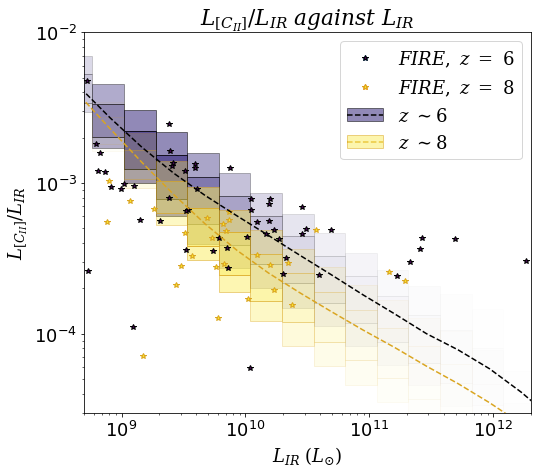

In [19]:
f, a = plt.subplots()

plt.title(r'$L_{[C_{II}]}/L_{IR}\ against\ L_{IR}$')

p6 = a.plot(fire_ir_z6, (fire_cii_z6/fire_ir_z6), c = '#440154FF', marker = '*', markeredgecolor='k', label = r'$FIRE,\ z\ =\ 6$', linestyle = "None")
p6l = a.plot(np.nan, np.nan, '*')

p8 = a.plot(fire_ir_z8, (fire_cii_z8/fire_ir_z8), c = '#FDE725FF', marker = '*', markeredgecolor='#DAA520', label = r'$FIRE,\ z\ =\ 8$', linestyle = "None")
p8l = a.plot(np.nan, np.nan, '*')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$L_{IR}\ (L_{\odot})$')
plt.ylabel(r'$L_{[C_{II}]}/L_{IR}$')
plt.xlim([5*(10**8), 2*(10**12)])
plt.ylim([3*(10**(-5)), (10**(-2))])

for i in range(len(ir_center)):
    
    a.fill_between((ir_bins[i], ir_bins[i+1]), perc68_down_v1z6[i], perc68_up_v1z6[i], edgecolor='k', facecolor='#241571', alpha = 0.75*alpha_dens_z6[i])
    
    a.fill_between((ir_bins[i], ir_bins[i+1]), perc95_down_v1z6[i], perc68_down_v1z6[i], edgecolor='k', facecolor='#241571', alpha = 0.5*alpha_dens_z6[i])
    a.fill_between((ir_bins[i], ir_bins[i+1]), perc68_up_v1z6[i], perc95_up_v1z6[i], edgecolor='k', facecolor='#241571', alpha = 0.5*alpha_dens_z6[i])
    
    #a.fill_between((ir_bins[i], ir_bins[i+1]), perc997_down_v1z6[i], perc95_down_v1z6[i], facecolor='#241571', alpha = 0.25*alpha_dens[i])
    #a.fill_between((ir_bins[i], ir_bins[i+1]), perc95_up_v1z6[i], perc997_up_v1z6[i], facecolor='#241571', alpha = 0.25*alpha_dens[i])

    
    a.fill_between((ir_bins[i], ir_bins[i+1]), perc68_down_v1z8[i], perc68_up_v1z8[i], edgecolor='#DAA520', facecolor='#FBEC5D', alpha = 0.75*alpha_dens_z8[i])
    
    a.fill_between((ir_bins[i], ir_bins[i+1]), perc95_down_v1z8[i], perc68_down_v1z8[i], edgecolor='#DAA520', facecolor='#FBEC5D', alpha = 0.5*alpha_dens_z8[i])
    a.fill_between((ir_bins[i], ir_bins[i+1]), perc68_up_v1z8[i], perc95_up_v1z8[i], edgecolor='#DAA520', facecolor='#FBEC5D', alpha = 0.5*alpha_dens_z8[i])
    
    #a.fill_between((ir_bins[i], ir_bins[i+1]), perc997_down_v1z8[i], perc95_down_v1z8[i], facecolor='#FBEC5D', alpha = 0.25*alpha_dens[i])
    #a.fill_between((ir_bins[i], ir_bins[i+1]), perc95_up_v1z8[i], perc997_up_v1z8[i], facecolor='#FBEC5D', alpha = 0.25*alpha_dens[i])
    
p01 = a.plot(ir_center, mean_v1z6, color = 'k', linestyle = '--')
p02 = a.fill(np.nan, np.nan, alpha=0.5, edgecolor='k', facecolor='#241571')

p03 = a.plot(ir_center, mean_v1z8, color = '#DAA520', linestyle = '--')
p04 = a.fill(np.nan, np.nan, alpha=0.5, edgecolor='#DAA520', facecolor='#FBEC5D')

a.legend([(p6l[0], p6[0]), (p8l[0], p8[0]), (p02[0], p01[0]), (p03[0], p04[0]), ], [(r'$FIRE,\ z\ =\ 6$'), (r'$FIRE,\ z\ =\ 8$'), (r'$z\ \sim 6$'), (r'$z\ \sim 8$'), ], bbox_to_anchor = (1,1))

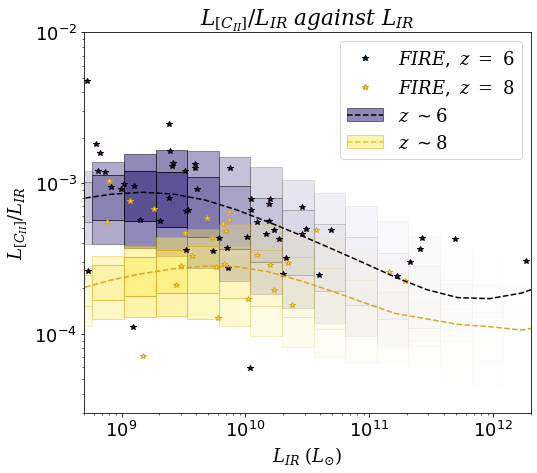

In [50]:
f, a = plt.subplots()

plt.title(r'$L_{[C_{II}]}/L_{IR}\ against\ L_{IR}$')

p6 = a.plot(fire_ir_z6, (fire_cii_z6/fire_ir_z6), c = '#440154FF', marker = '*', markeredgecolor='k', label = r'$FIRE,\ z\ =\ 6$', linestyle = "None")
p6l = a.plot(np.nan, np.nan, '*')

p8 = a.plot(fire_ir_z8, (fire_cii_z8/fire_ir_z8), c = '#FDE725FF', marker = '*', markeredgecolor='#DAA520', label = r'$FIRE,\ z\ =\ 8$', linestyle = "None")
p8l = a.plot(np.nan, np.nan, '*')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$L_{IR}\ (L_{\odot})$')
plt.ylabel(r'$L_{[C_{II}]}/L_{IR}$')
plt.xlim([5*(10**8), 2*(10**12)])
plt.ylim([3*(10**(-5)), (10**(-2))])

for i in range(len(ir_center)):
    
    a.fill_between((ir_bins[i], ir_bins[i+1]), perc68_down_v2z6[i], perc68_up_v2z6[i], edgecolor='k', facecolor='#241571', alpha = 0.75*alpha_dens_z6[i])
    
    a.fill_between((ir_bins[i], ir_bins[i+1]), perc95_down_v2z6[i], perc68_down_v2z6[i], edgecolor='k', facecolor='#241571', alpha = 0.5*alpha_dens_z6[i])
    a.fill_between((ir_bins[i], ir_bins[i+1]), perc68_up_v2z6[i], perc95_up_v2z6[i], edgecolor='k', facecolor='#241571', alpha = 0.5*alpha_dens_z6[i])
    
    #a.fill_between((ir_bins[i], ir_bins[i+1]), perc997_down_v2z6[i], perc95_down_v2z6[i], facecolor='#241571', alpha = 0.25*alpha_dens[i])
    #a.fill_between((ir_bins[i], ir_bins[i+1]), perc95_up_v2z6[i], perc997_up_v2z6[i], facecolor='#241571', alpha = 0.25*alpha_dens[i])

    
    a.fill_between((ir_bins[i], ir_bins[i+1]), perc68_down_v2z8[i], perc68_up_v2z8[i], edgecolor='#DAA520', facecolor='#FBEC5D', alpha = 0.75*alpha_dens_z8[i])
    
    a.fill_between((ir_bins[i], ir_bins[i+1]), perc95_down_v2z8[i], perc68_down_v2z8[i], edgecolor='#DAA520', facecolor='#FBEC5D', alpha = 0.5*alpha_dens_z8[i])
    a.fill_between((ir_bins[i], ir_bins[i+1]), perc68_up_v2z8[i], perc95_up_v2z8[i], edgecolor='#DAA520', facecolor='#FBEC5D', alpha = 0.5*alpha_dens_z8[i])
    
    #a.fill_between((ir_bins[i], ir_bins[i+1]), perc997_down_v2z8[i], perc95_down_v2z8[i], facecolor='#FBEC5D', alpha = 0.25*alpha_dens[i])
    #a.fill_between((ir_bins[i], ir_bins[i+1]), perc95_up_v2z8[i], perc997_up_v2z8[i], facecolor='#FBEC5D', alpha = 0.25*alpha_dens[i])
    
p01 = a.plot(ir_center, mean_v2z6, color = 'k', linestyle = '--')
p02 = a.fill(np.nan, np.nan, alpha=0.5, edgecolor='k', facecolor='#241571')

p03 = a.plot(ir_center, mean_v2z8, color = '#DAA520', linestyle = '--')
p04 = a.fill(np.nan, np.nan, alpha=0.5, edgecolor='#DAA520', facecolor='#FBEC5D')

a.legend([(p6l[0], p6[0]), (p8l[0], p8[0]), (p02[0], p01[0]), (p03[0], p04[0]), ], [(r'$FIRE,\ z\ =\ 6$'), (r'$FIRE,\ z\ =\ 8$'), (r'$z\ \sim 6$'), (r'$z\ \sim 8$'), ], bbox_to_anchor = (1,1))

# WHY

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy.units as u # I use astropy units in everything, very helpful for bookkeeping/debugging

from lim import lim # The base intensity mapping object

matplotlib.rcParams.update({'font.size': 18,'figure.figsize':[8,7]}) # Make figures better
#matplotlib.rcParams,update({}'figure.figsize'] = [8,7]
from scipy.ndimage import gaussian_filter
plt.rcParams["mathtext.fontset"] = "dejavuserif"

In [2]:
# Initialize LineModel with default model
m = lim()
m_cii = lim('Lichen_v4', doSim = True)
m_cii_v1 = lim('Lichen', doSim = True)

Input cosmological model does not match simulations
Setting analytic cosmology to match simulation
Input cosmological model does not match simulations
Setting analytic cosmology to match simulation


In [3]:
m_cii.update(model_par = {'zdex': 0.4,
 'M0': 1900000000.0,
 'Mmin': 20000000000,
 'alpha_MH1': 0.74,
 'alpha_LCII': 0.024,
 'alpha0': -1.412,
 'gamma0': 0.31,
 'BehrooziFile': 'sfr_reinterp.dat'},
            nuObs = 270*u.GHz,
            Delta_nu = 40*u.GHz,
             dnu = 2.8*u.GHz,
            Omega_field = 4*u.deg**2,
            catalogue_file  = '/home/dongwooc/scratchspace/pprun_hiz_npz/COMAP_z5.8-7.9_960Mpc_seed_13819.npz')

In [3]:
m_cii_v1.update(nuObs = 270*u.GHz,
                Delta_nu = 28*u.GHz,
                dnu = 2.8*u.GHz,
                Omega_field = 4*u.deg**2,
                catalogue_file  = '/home/dongwooc/scratchspace/pprun_hiz_npz/COMAP_z5.8-7.9_960Mpc_seed_13819.npz')

In [4]:
a = lambda z:1/(1.+z)
# Behroozi et al 2013a parameters
nu = lambda z:np.exp(-4*a(z)**2)
log10_eps = lambda z:-1.777-0.006*(a(z)-1)*nu(z)-0.119*(a(z)-1)
log10_M1 = lambda z:11.514+(-1.793*(a(z)-1)-0.251*z)*nu(z)
alpha = lambda z:-1.412+0.731*(a(z)-1)*nu(z)
delta = lambda z:3.508+(2.608*(a(z)-1)-0.043*z)*nu(z)
gamma_f = lambda z:0.316+(1.319*(a(z)-1)+0.279*z)*nu(z)
f = lambda x, z:-np.log10(10**(alpha(z)*x)+1)+delta(z)*(np.log10(1+np.exp(x)))**gamma_f(z)/(1+np.exp(10**(-x)))
xi = lambda z:0.218-0.023*(a(z)-1)

def stellar_m(halo_m,z,scatter=False):
    sm = 10**(log10_eps(z)+log10_M1(z)+f(np.log10(halo_m/(10**log10_M1(z))),z)-f
(0,z))
    if scatter:
        rand = np.random.lognormal(-0.5*(xi(z)*np.log(10))**2,xi(z)*np.log(10))
        return sm*rand
    else:
        return sm

    
from limlam_mocker import limlam_mocker as llm
from limlam_mocker.limlam_mocker import add_log_normal_scatter
import scipy as sp
import scipy.interpolate
sigma_sfr = 0.3

tablepath = '/mnt/scratch-lustre/horlaville/clara_limlam/limCode2020-master_clara_2/sfr_reinterp.dat'

dat_zp1, dat_logm, dat_logsfr, _ = np.loadtxt(tablepath, unpack=True)
dat_logzp1 = np.log10(dat_zp1)
dat_sfr    = 10.**dat_logsfr
dat_logzp1  = np.unique(dat_logzp1)    # log(z), 1D 
dat_logm    = np.unique(dat_logm)      # log(Mhalo), 1D        
dat_sfr     = np.reshape(dat_sfr, (dat_logm.size, dat_logzp1.size))
sfr_interp_tab = sp.interpolate.RectBivariateSpline(dat_logm, dat_logzp1, dat_sfr, kx=1, ky=1)

In [6]:
halo_ms = m_cii_v1.halos.M
halo_zs6 = m_cii_v1.halos.redshift

halo_sfr = sfr_interp_tab.ev(np.log10(halo_ms), np.log10(halo_zs6 + 1))
halo_IR = halo_sfr*(1.36*(10**10))
halo_IR_z6 = add_log_normal_scatter(halo_IR, 0.3, seed = 23)

halos_cii_v1_z6 = m_cii_v1.L_halos.value

In [7]:
fire_galaxies_z6 = '/mnt/scratch-lustre/horlaville/clara_limlam/limCode2020-master_clara_2/fire_galaxies/fire_galaxies_z6.dat'
massive_z6, log_cii_z6, log_ir_z6 = np.loadtxt(fire_galaxies_z6, unpack=True)

mass_fire_z6 = massive_z6 < 0
fire_box_z6 = massive_z6 >= 0
fire_zs_z6 = [6 for i in range(len(massive_z6))]

fire_cii_z6 = 10**(log_cii_z6)
fire_ir_z6 = 10**(log_ir_z6)


fire_galaxies_z8 = '/mnt/scratch-lustre/horlaville/clara_limlam/limCode2020-master_clara_2/fire_galaxies/fire_galaxies_z8.dat'
massive_z8, log_cii_z8, log_ir_z8 = np.loadtxt(fire_galaxies_z8, unpack=True)

mass_fire_z8 = massive_z8 < 0
fire_box_z8 = massive_z8 >= 0
fire_zs_z8 = [8 for i in range(len(massive_z8))]

fire_cii_z8 = 10**(log_cii_z8)
fire_ir_z8 = 10**(log_ir_z8)

In [9]:
z6 = (halo_zs6 > 5.99) & (halo_zs6 < 6.01)

In [58]:
z8 = (halo_zs8 > 7.8)

In [10]:
np.shape(halo_IR_z6)

(1179000,)

In [61]:
np.shape(halos_cii_v1[z8])

(50868,)

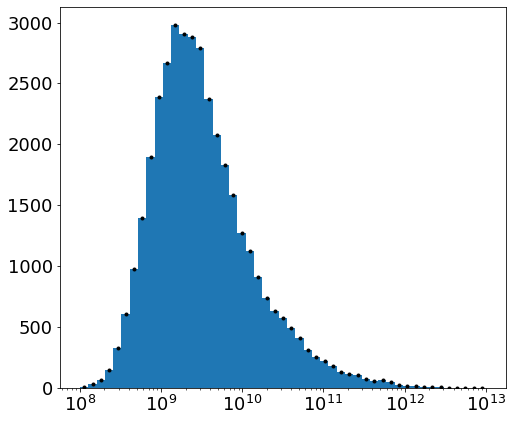

In [11]:
ir_binning = np.logspace(8, 13, 50)
n_ir_z6, _, _= plt.hist(halo_IR_z6[z6], bins = ir_binning)

ir_bin_center = (ir_binning[:-1] + ir_binning[1:]) / 2
plt.plot(ir_bin_center, n_ir_z6, '.k')
plt.xscale('log')

In [13]:
spec_bins_z6 = np.digitize(halo_IR_z6[z6], ir_binning)

In [16]:
med_z6 = np.median((halos_cii_v1_z6/halo_IR_z6)[z6][spec_bins_z6])

In [20]:
spec_bins_z6

array([36, 20, 19, ..., 17, 14, 13])

In [19]:
np.shape(spec_bins_z6)

(37679,)

ValueError: x and y must have same first dimension, but have shapes (49,) and (1,)

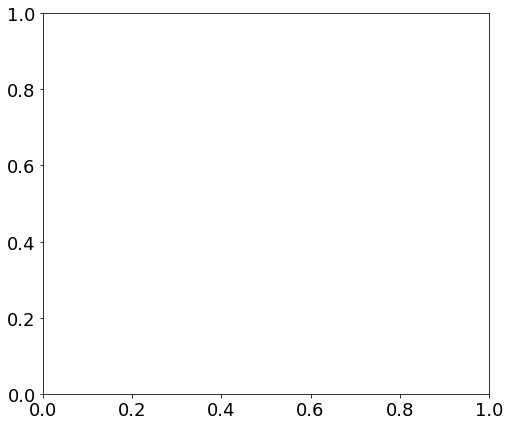

In [17]:
plt.plot(ir_bin_center, med_z6, label = 'z = 6')
#plt.plot(ir_bin_center, med_z8, label = 'z = 8')
plt.plot(fire_ir_z6, (fire_cii_z6/fire_ir_z6), c = '#440154FF', marker = '*', markeredgecolor='k', label = r'$FIRE,\ z\ =\ 6$', linestyle = "None")
plt.plot(fire_ir_z8, (fire_cii_z8/fire_ir_z8), c = '#FDE725FF', marker = '*', markeredgecolor='#DAA520', label = r'$FIRE,\ z\ =\ $8', linestyle = "None")


plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$L_{IR}\ (L_{\odot})$')
plt.ylabel(r'$L_{[C_{II}]}/L_{IR}$')
plt.xlim([5*(10**8), 2*(10**12)])
plt.ylim([3*(10**(-5)), (10**(-2))])
plt.legend()

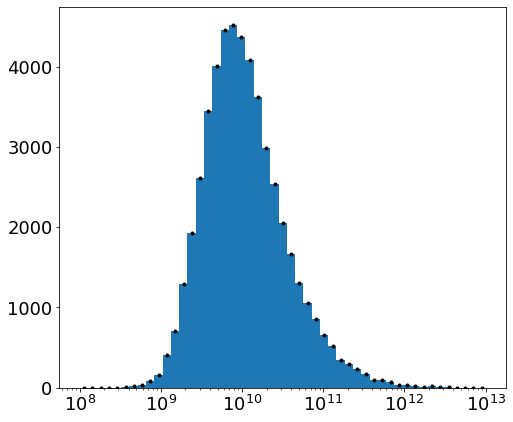

In [62]:
ir_binning = np.logspace(8, 13, 50)
n_ir, _, _= plt.hist(halo_IR[z8], bins = ir_binning)

ir_bin_center = (ir_binning[:-1] + ir_binning[1:]) / 2
plt.plot(ir_bin_center, n_ir, '.k')
plt.xscale('log')

In [41]:
ind = [0 for i in range(len(ir_bin_center))]
med = [0 for i in range(len(ir_bin_center))]
mean = [0 for i in range(len(ir_bin_center))]

In [42]:
for i in range(len(ir_bin_center)):
    
    ind[i] = (halo_IR[z6] >= ir_binning[i]) & (halo_IR[z6] <= ir_binning[i+1])
        
    med[i] = np.median((halos_cii_v1/halo_IR)[z6][ind[i]])
    mean[i] = np.mean((halos_cii_v1/halo_IR)[z6][ind[i]])

/cita/modules/python/3.10.2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/cita/modules/python/3.10.2/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [64]:
def irbin(halo_ir, halo_cii, ir_bin, zsel):
    
    ir_center = (ir_bin[:-1] + ir_bin[1:]) / 2
    
    spec_bin = [0 for i in range(len(ir_center))]
    med = [0 for i in range(len(ir_center))]
    mean = [0 for i in range(len(ir_center))]
    
    for i in range(len(ir_bin_center)):
    
        spec_bin[i] = (halo_IR[zsel] >= ir_binning[i]) & (halo_IR[zsel] <= ir_binning[i+1])
        
        med[i] = np.median((halo_cii/halo_ir)[zsel][spec_bin[i]])

    return ir_center, med

In [50]:
ir_bin_center, med = irbin(halo_IR, halos_cii_v1, ir_binning, z6)

/cita/modules/python/3.10.2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/cita/modules/python/3.10.2/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [65]:
ir_bin_center, med_z8 = irbin(halo_IR, halos_cii_v1_z8, ir_binning, z8)

/cita/modules/python/3.10.2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/cita/modules/python/3.10.2/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


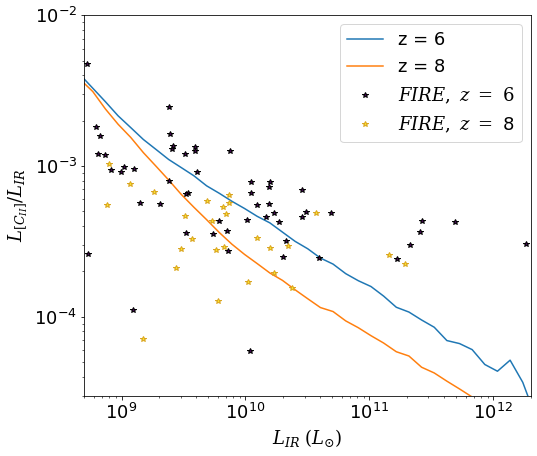

In [66]:
plt.plot(ir_bin_center, med, label = 'z = 6')
plt.plot(ir_bin_center, med_z8, label = 'z = 8')
plt.plot(fire_ir_z6, (fire_cii_z6/fire_ir_z6), c = '#440154FF', marker = '*', markeredgecolor='k', label = r'$FIRE,\ z\ =\ 6$', linestyle = "None")
plt.plot(fire_ir_z8, (fire_cii_z8/fire_ir_z8), c = '#FDE725FF', marker = '*', markeredgecolor='#DAA520', label = r'$FIRE,\ z\ =\ $8', linestyle = "None")


plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$L_{IR}\ (L_{\odot})$')
plt.ylabel(r'$L_{[C_{II}]}/L_{IR}$')
plt.xlim([5*(10**8), 2*(10**12)])
plt.ylim([3*(10**(-5)), (10**(-2))])
plt.legend()

In [68]:
halo_zs

array([7.83757443, 7.74022512, 7.74007959, ..., 6.91865502, 6.91553758,
       6.9239343 ])

In [27]:
plt.plot(halo_IR, halos_cii_v1, label = 'z = 6')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$L_{IR}\ (L_{\odot})$')
plt.ylabel(r'$L_{[C_{II}]}/L_{IR}$')
plt.xlim([5*(10**8), 2*(10**12)])
plt.ylim([3*(10**(-5)), (10**(-2))])
plt.legend()

OverflowError: Exceeded cell block limit in Agg.  Please set the value of rcParams['agg.path.chunksize'], (currently 0) to be greater than 100 or increase the path simplification threshold(rcParams['path.simplify_threshold'] = 0.111111111111 by default and path.simplify_threshold = 0.111111111111 on the input).

<Figure size 576x504 with 1 Axes>

In [12]:
plt.plot(fire_ir_z6, (fire_cii_z6/fire_ir_z6), c = '#440154FF', marker = '*', markeredgecolor='k', label = r'$FIRE,\ z\ =\ 6$', linestyle = "None")
plt.plot(fire_ir_z8, (fire_cii_z8/fire_ir_z8), c = '#FDE725FF', marker = '*', markeredgecolor='#DAA520', label = r'$FIRE,\ z\ =\ $8', linestyle = "None")

plt.plot(halo_IR, halos_cii_v1/halo_IR, label = 'z = 6')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$L_{IR}\ (L_{\odot})$')
plt.ylabel(r'$L_{[C_{II}]}/L_{IR}$')
plt.xlim([5*(10**8), 2*(10**12)])
plt.ylim([3*(10**(-5)), (10**(-2))])
plt.legend()


OverflowError: Exceeded cell block limit in Agg.  Please set the value of rcParams['agg.path.chunksize'], (currently 0) to be greater than 100 or increase the path simplification threshold(rcParams['path.simplify_threshold'] = 0.111111111111 by default and path.simplify_threshold = 0.111111111111 on the input).

<Figure size 576x504 with 1 Axes>